## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

## Fu (1981)
```
AET/P = 1 + PET/P - (1 + (PET/P)^w )^1/w
```

## Create data

In [3]:
np.random.seed(12)
n = 200
pet_m = np.linspace(1,1000,200)
pet = pet_m + 300*np.random.randn(n)
p = 400 + np.random.randn(n)
pet_p = pet/p
pet_p[pet_p < 0] = 0  # force pet_p >= 0
w = 2.6
aet_p = (1 + (pet_p) - ((1 + (pet_p)**w)**(1/w)))
discharge = (1-aet_p)*p
t = np.arange(n)

## Quantile regression

In [4]:
data = pd.DataFrame({'time': t, 'discharge': discharge})
mod = smf.quantreg('discharge~time', data)
quants = np.array([0.25, 0.5, 0.75])
res_all = [mod.fit(q=q) for q in quants]
res_ols = smf.ols('discharge~time', data).fit()

## Create x for prediction

In [6]:
x_p = np.linspace(data.time.min(), data.time.max(), 50)
df_p = pd.DataFrame({'time': x_p})

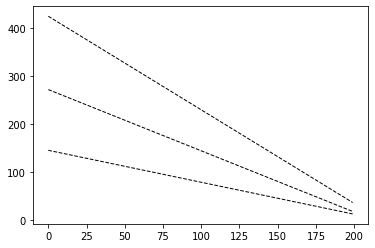

In [7]:
for qm, res in zip(quants, res_all):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    plt.plot(x_p, res.predict({'time': x_p}), linestyle='--', lw=1, color='k')

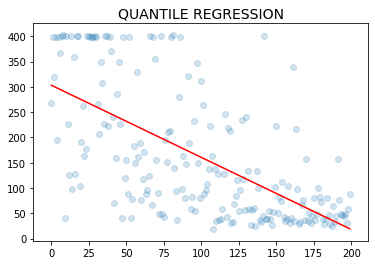

In [8]:
y_ols_predicted = res_ols.predict(df_p)
plt.plot(x_p, y_ols_predicted, color='red', label='OLS')
plt.scatter(data.time, data.discharge, alpha=.2)
plt.title('QUANTILE REGRESSION', fontsize=14)
plt.show()